## Part One: Exploratory Analysis

The file named `task1_transport_data.csv` consists of data from a fictional transportation company. It details the number of orders that customers of this company make on any given day, with some additional variables. You should:

• Provide exploratory analysis of the dataset.

• Summarise and explain the key trends in the data, providing visualisations and tabular representations as necessary.

• Construct a model or models to predict the number of jobs that this transportation company will complete on any given day.

• Explain what factors you think are significant and insignificant in contributing to the number of jobs completed, and any other information about your model that you think is important.

## Data Cleaning

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
from datetime import timedelta

In [341]:
transport = pd.read_csv('task1_transport_data.csv')
transport.head()

,date,orders,circumstance,drivers_available
0,2012-01-02,24899.0,dry,4223.0
1,2012-01-03,24774.0,dry,5450.0
2,2012-01-04,24498.0,dry,NaN
3,2012-01-05,25083.0,dry,4691.0
4,2012-01-06,24676.0,dry,5308.0


In [342]:
transport.tail()

,date,orders,circumstance,drivers_available
780,2014-02-20,38620.0,dry,7868.0
781,2014-02-21,38424.0,dry,NaN
782,2014-02-22,38923.0,dry,6642.0
783,2014-02-23,39096.0,dry,7472.0
784,2014-02-24,39055.0,dry,7960.0


In [343]:
transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               782 non-null    object 
 1   orders             769 non-null    float64
 2   circumstance       784 non-null    object 
 3   drivers_available  777 non-null    float64
dtypes: float64(2), object(2)
memory usage: 24.7+ KB


I will first check the missing values in the date column. 

In [344]:
transport[transport['date'].isnull()]

,date,orders,circumstance,drivers_available
14,NaN,26125.0,dry,NaN
440,NaN,29532.0,dry,6899.0
608,NaN,31501.0,dry,5326.0


In [345]:
transport.iloc[12:17]

,date,orders,circumstance,drivers_available
12,2012-01-14,26056.0,dry,5257.0
13,2012-01-15,25930.0,dry,5242.0
14,NaN,26125.0,dry,NaN
15,2012-01-17,25997.0,dry,5930.0
16,2012-01-18,25910.0,dry,5889.0


In [346]:
transport.iloc[438:443]

,date,orders,circumstance,drivers_available
438,2013-03-15,29441.0,very_rainy,5217.0
439,2013-03-16,29423.0,dry,6971.0
440,NaN,29532.0,dry,6899.0
441,2013-03-18,29547.0,dry,4507.0
442,2013-03-19,29661.0,dry,5298.0


In [347]:
transport.iloc[606:611]

,date,orders,circumstance,drivers_available
606,2013-08-30,31165.0,dry,6497.0
607,2013-08-31,30740.0,dry,6840.0
608,NaN,31501.0,dry,5326.0
609,2013-09-02,31387.0,dry,6124.0
610,2013-09-03,31256.0,rainy,6898.0


The data is ordered in chronological order by date so I will impute the missing values with the correct dates. 

In [348]:
transport.at[14, 'date'] = '2012-01-16'
transport.at[440, 'date'] = '2013-03-17'
transport.at[608, 'date'] = '2013-09-01'

There is one missing 'circumstance' value

In [349]:
transport[transport['circumstance'].isnull()]

,date,orders,circumstance,drivers_available
347,2012-12-14,31621.0,NaN,6869.0


In [350]:
transport.iloc[345:350]

,date,orders,circumstance,drivers_available
345,2012-12-12,27507.0,dry,NaN
346,2012-12-13,27579.0,dry,6973.0
347,2012-12-14,31621.0,NaN,6869.0
348,2012-12-15,27135.0,dry,5258.0
349,2012-12-16,27658.0,dry,4881.0


I am going to fill the missing value for circumstance in row 347 with 'dry. The most common circumstance in the dataset is 'dry', as the date of this row of data was December I wanted to check the weather on the days before and after in case of rain. As the weather on these days was also 'dry' I will go ahead with my assumption that this day was also 'dry'.

In [351]:
transport.at[347, 'circumstance'] = 'dry'

In [352]:
transport.circumstance.value_counts()

dry           634
very_rainy     76
rainy          70
strike          3
RAINY           1
dr              1
Name: circumstance, dtype: int64

I will also change the mislablled values.

In [353]:
def circs(row):
    if row == 'RAINY':
        return 'rainy'
    elif row == 'dr':
        return 'dry'
    else:
        return row

In [354]:
transport['circumstance'] = transport.circumstance.apply(circs)

In [355]:
transport.circumstance.value_counts()

dry           635
very_rainy     76
rainy          71
strike          3
Name: circumstance, dtype: int64

Looking at the missing values for the number of drivers available. 

In [356]:
transport[transport['drivers_available'].isnull()]

,date,orders,circumstance,drivers_available
2,2012-01-04,24498.0,dry,NaN
14,2012-01-16,26125.0,dry,NaN
49,2012-02-20,26425.0,dry,NaN
64,2012-03-06,27760.0,dry,NaN
345,2012-12-12,27507.0,dry,NaN
397,2013-02-02,29337.0,dry,NaN
748,2014-01-19,37264.0,dry,NaN
781,2014-02-21,38424.0,dry,NaN


I have time series data, so rather than just imputing the mean or median value, let's have a look at what the number of drivers looks like over time.

In [357]:
transport['date']= pd.to_datetime(transport.date)

In [358]:
transport.set_index('date', inplace=True, drop=True)
transport.index.name = None

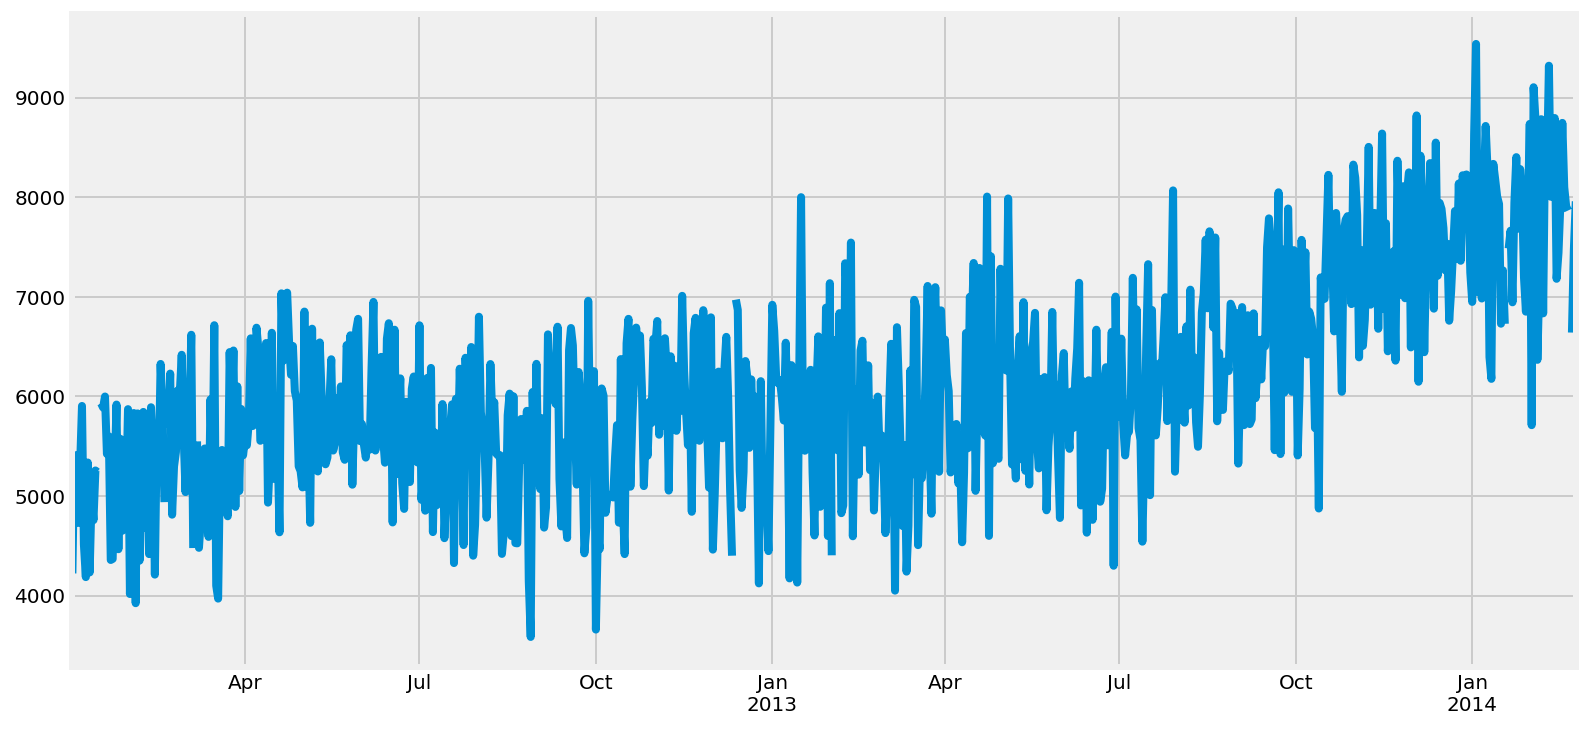

In [359]:
transport['drivers_available'].plot(figsize=(12, 6))
plt.show()

I'm going to fill the missing driver numbers with the 5 day rolling mean. 

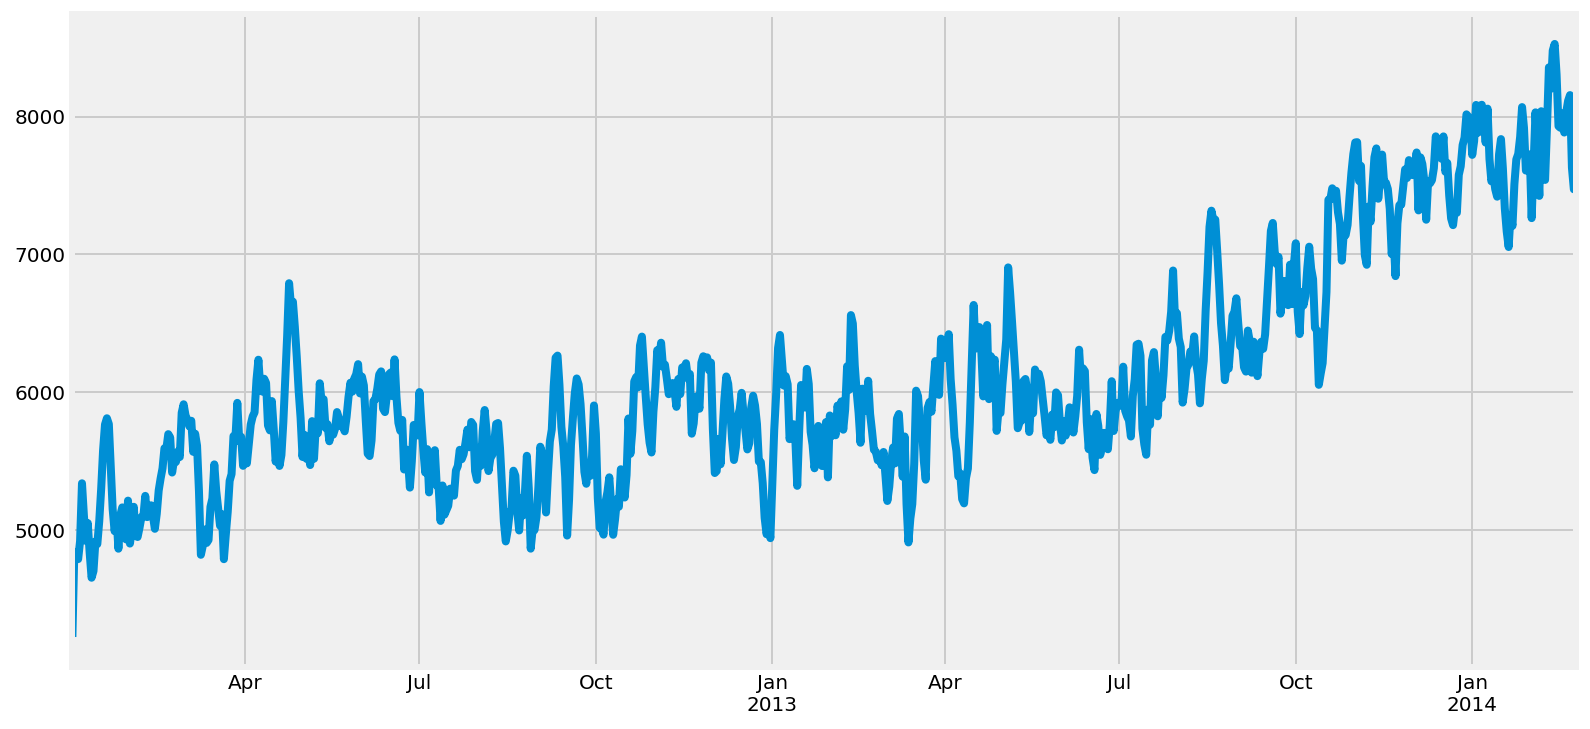

In [360]:
transport.drivers_available.rolling(5, min_periods=1).mean().plot(figsize=(12, 6))
plt.show()

In [361]:
transport['drivers_available'] = transport.drivers_available.fillna(transport.drivers_available.rolling(5, min_periods=1).mean())

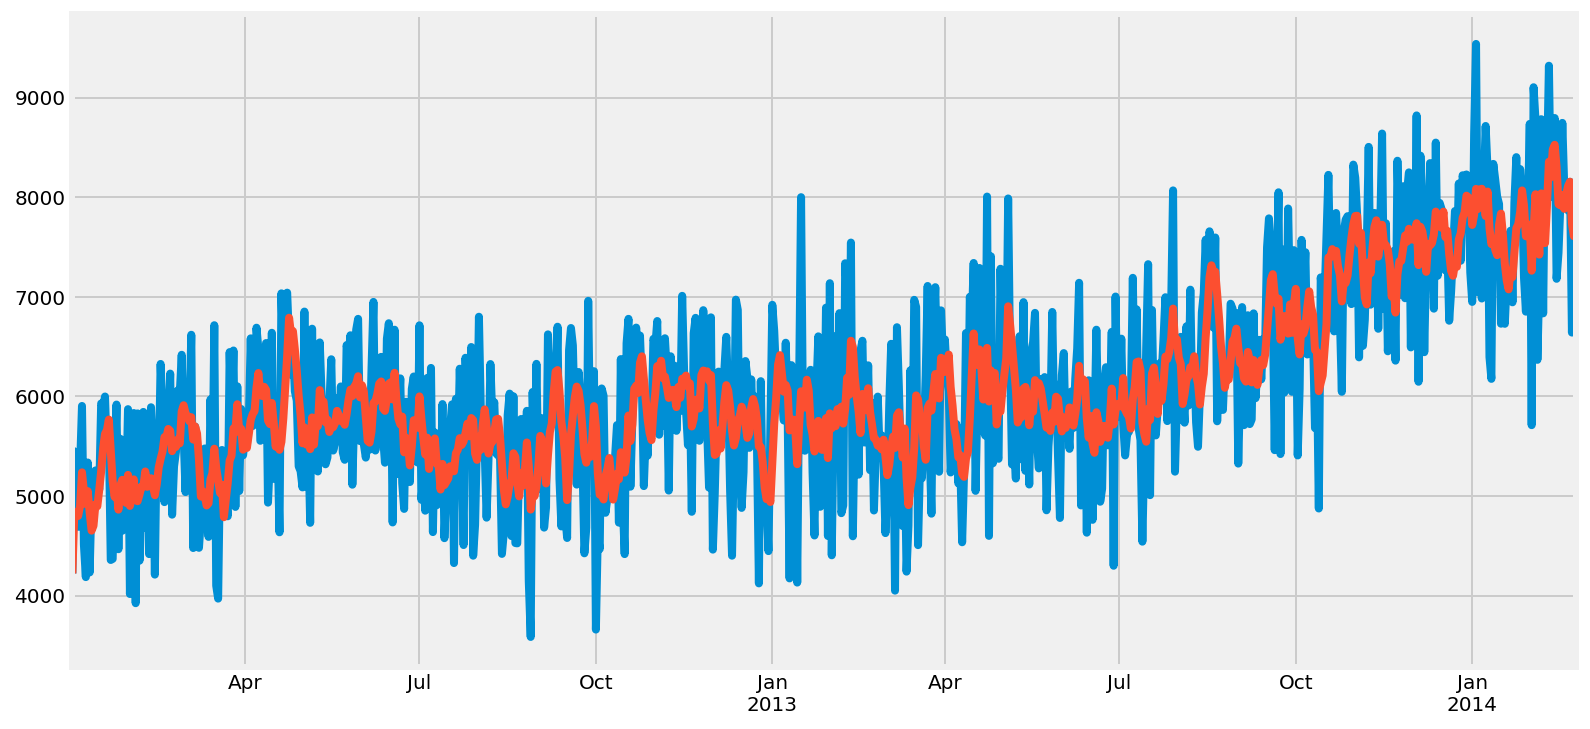

In [362]:
transport['drivers_available'].plot(figsize=(12, 6))
transport.drivers_available.rolling(5, min_periods=1).mean().plot(figsize=(12, 6))
plt.show()

There are 16 missing values in the orders column

In [363]:
transport[transport['orders'].isnull()]

,orders,circumstance,drivers_available
2012-01-24,NaN,dry,5206.0
2012-04-15,NaN,dry,6640.0
2012-05-02,NaN,dry,6853.0
2012-06-30,NaN,dry,5337.0
2012-07-16,NaN,dry,5234.0
2012-09-02,NaN,dry,5070.0
2012-09-03,NaN,dry,5782.0
2012-09-13,NaN,dry,4695.0
2013-03-22,NaN,dry,6210.0
2013-04-04,NaN,dry,5237.0


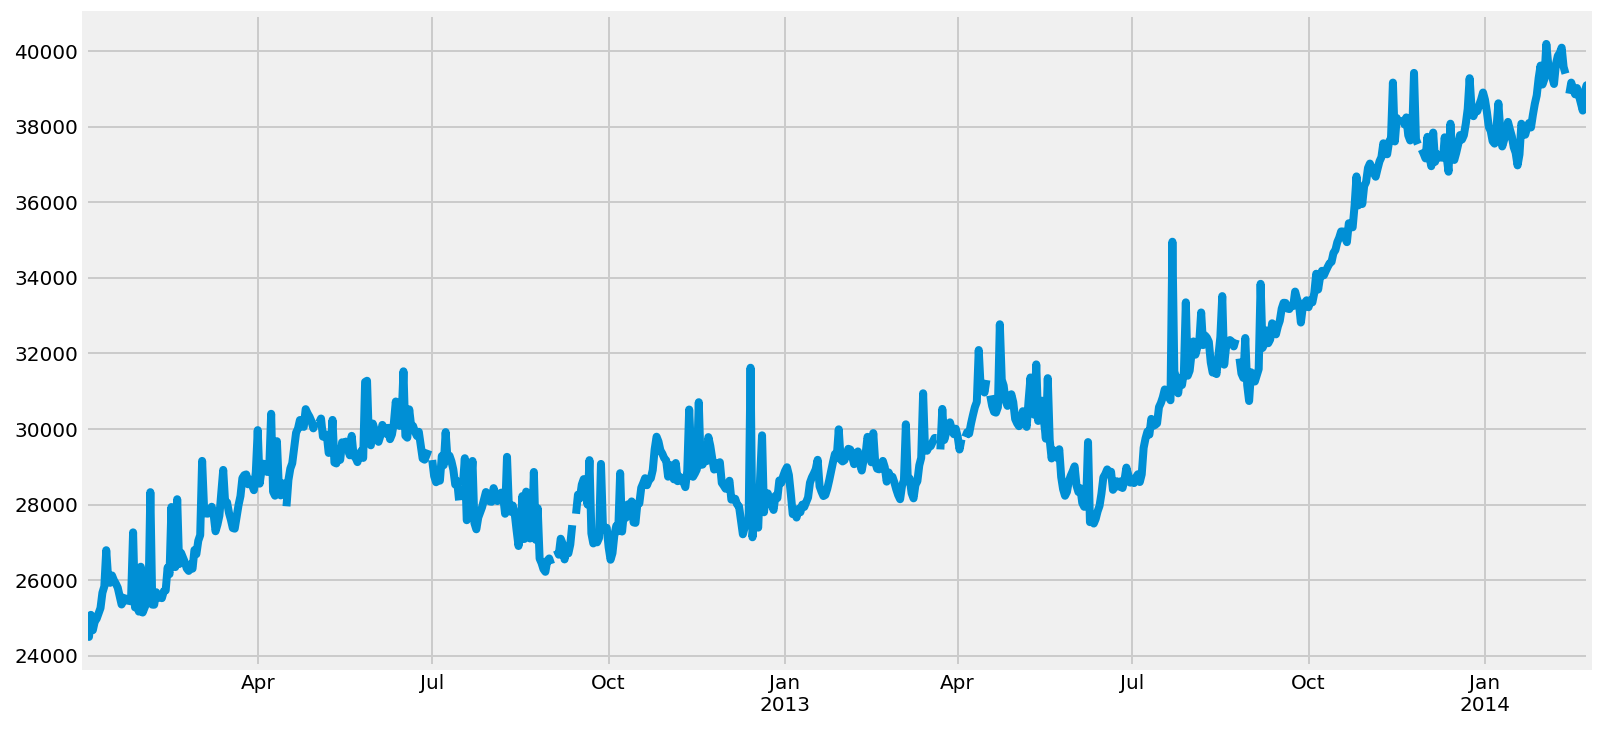

In [364]:
transport['orders'].plot(figsize=(12, 6))
plt.show()

I am undecided whether to drop these values, or to impute the rolling mean. For the analysis I will impute them, and then likely drop them for the modelling task as these will be the target variable.

In [365]:
transport['orders']= transport.orders.fillna(transport.orders.rolling(5, min_periods=1).mean())

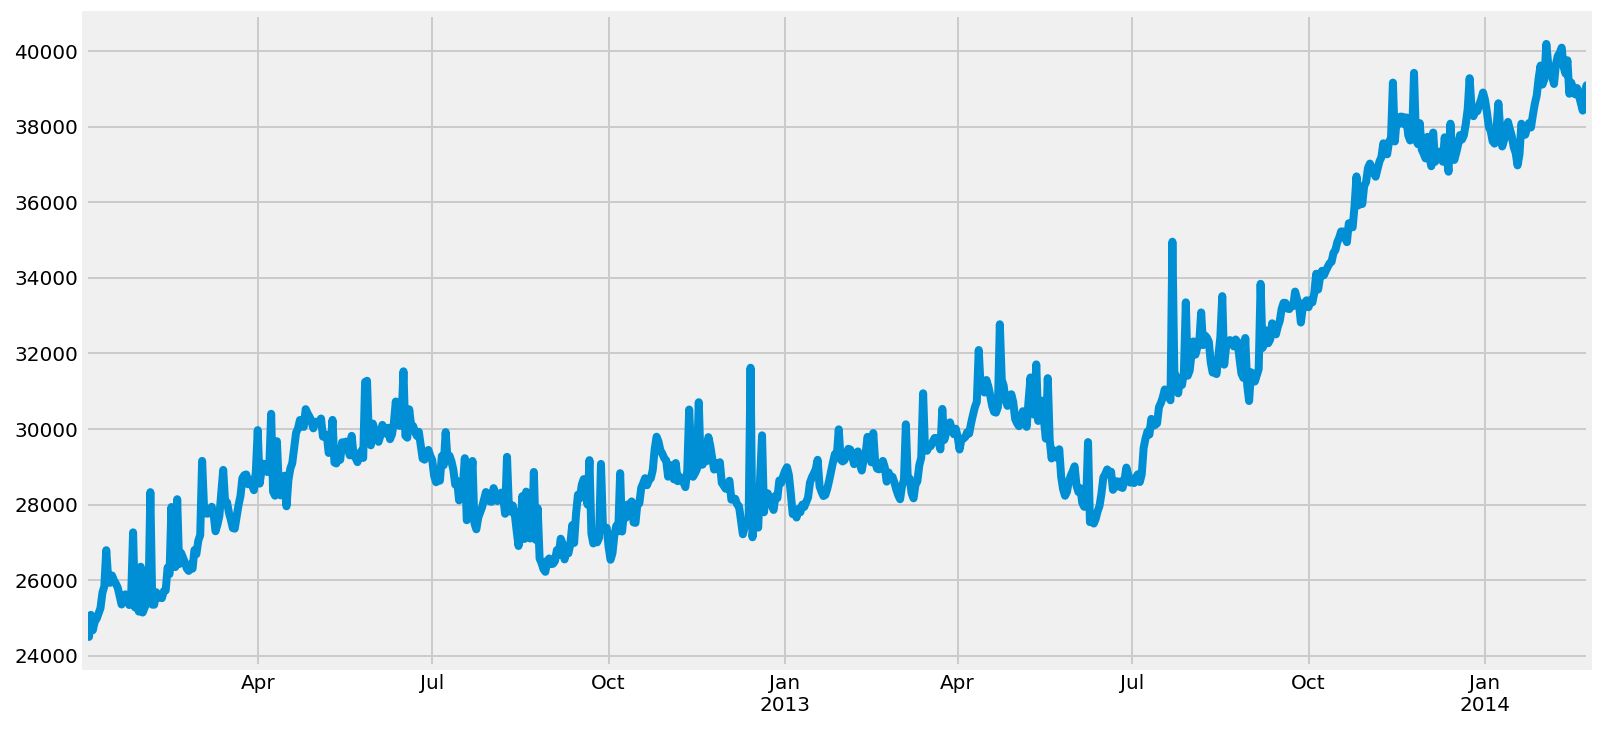

In [366]:
transport['orders'].plot(figsize=(12, 6))
plt.show()

## EDA

In [430]:
transport.head()

,orders,circumstance,drivers_available,weekday,month,year
2012-01-02,24899.0,dry,4223.0,Monday,Jan,2012
2012-01-03,24774.0,dry,5450.0,Tuesday,Jan,2012
2012-01-04,24498.0,dry,4836.5,Wednesday,Jan,2012
2012-01-05,25083.0,dry,4691.0,Thursday,Jan,2012
2012-01-06,24676.0,dry,5308.0,Friday,Jan,2012


In [367]:
transport.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 785 entries, 2012-01-02 to 2014-02-24
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   orders             785 non-null    float64
 1   circumstance       785 non-null    object 
 2   drivers_available  785 non-null    float64
dtypes: float64(2), object(1)
memory usage: 24.5+ KB


In [385]:
transport.describe(include= 'all')

,orders,circumstance,drivers_available,weekday,month,year
count,785.000000,785,785.000000,785,785,785.000000
unique,NaN,4,NaN,7,12,NaN
top,NaN,dry,NaN,Monday,Jan,NaN
freq,NaN,635,NaN,113,92,NaN
mean,30590.572293,NaN,6107.180255,NaN,NaN,2012.605096
std,3736.412715,NaN,1044.991060,NaN,NaN,0.616089
min,24498.000000,NaN,3585.000000,NaN,NaN,2012.000000
25%,28235.000000,NaN,5390.000000,NaN,NaN,2012.000000
50%,29311.000000,NaN,5987.000000,NaN,NaN,2013.000000
75%,31932.000000,NaN,6731.000000,NaN,NaN,2013.000000


I want to do some brief feature engineering of the date before diving any deeper into the EDA. 

In [369]:
transport['weekday'] = transport.index.weekday
transport['month'] = transport.index.month
transport['year'] = transport.index.year

In [370]:
transport['weekday'] = transport.weekday.map({0:'Monday',
                                              1: 'Tuesday',
                                              2: 'Wednesday',
                                              3: 'Thursday',
                                              4: 'Friday',
                                              5: 'Saturday',
                                              6: 'Sunday'})
transport['month'] = transport.month.map({1: 'Jan',
                                          2: 'Feb',
                                          3: 'Mar',
                                          4: 'Apr',
                                          5: 'May',
                                          6: 'Jun',
                                          7: 'Jul',
                                          8: 'Aug',
                                          9: 'Sep',
                                          10: 'Oct',
                                          11: 'Nov',
                                          12: 'Dec'})

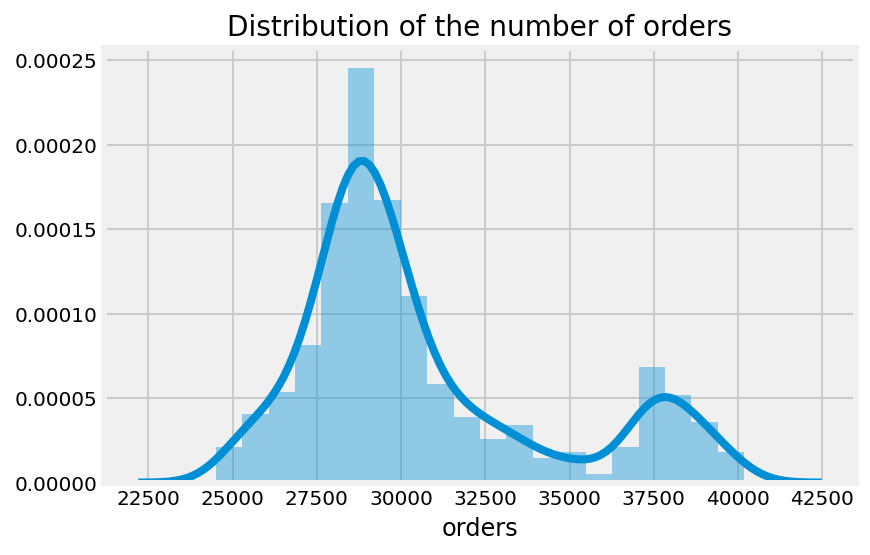

In [389]:
sns.distplot(transport.orders)
plt.title("Distribution of the number of orders", fontsize=14);
plt.savefig('orders_distribution.png')
plt.show()

We have a bimodal distribution of the number of orders per day.

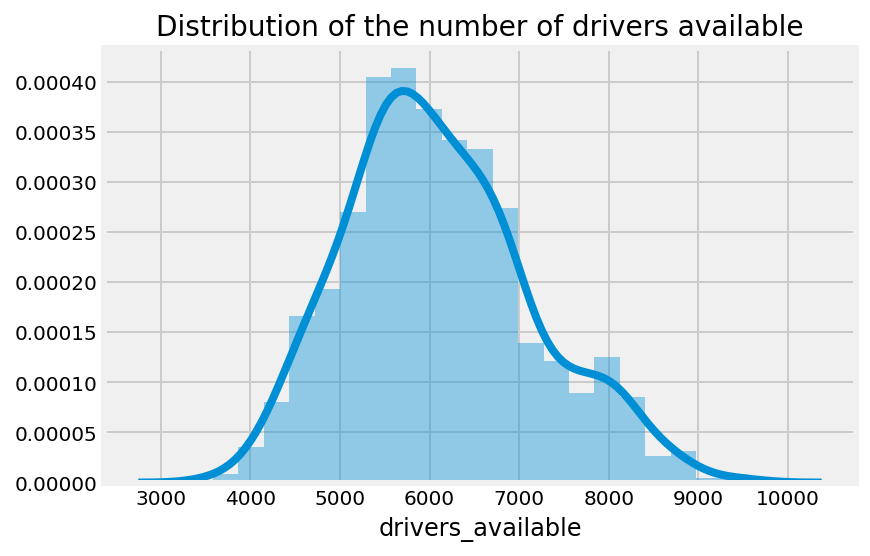

In [390]:
sns.distplot(transport.drivers_available)
plt.title("Distribution of the number of drivers available", fontsize=14);
plt.savefig('drivers_available_distribution.png')
plt.show()

The number of drivers available each day is more normally distributed.

In [373]:
transport.circumstance.unique()

array(['dry', 'rainy', 'very_rainy', 'strike'], dtype=object)

In [374]:
transport.circumstance.value_counts()

dry           635
very_rainy     76
rainy          71
strike          3
Name: circumstance, dtype: int64

In [375]:
transport[transport.circumstance == 'strike']

,orders,circumstance,drivers_available,weekday,month,year
2012-02-05,28329.0,strike,5830.0,Sunday,Feb,2012
2013-07-22,34955.0,strike,6333.0,Monday,Jul,2013
2014-02-02,40188.0,strike,9106.0,Sunday,Feb,2014


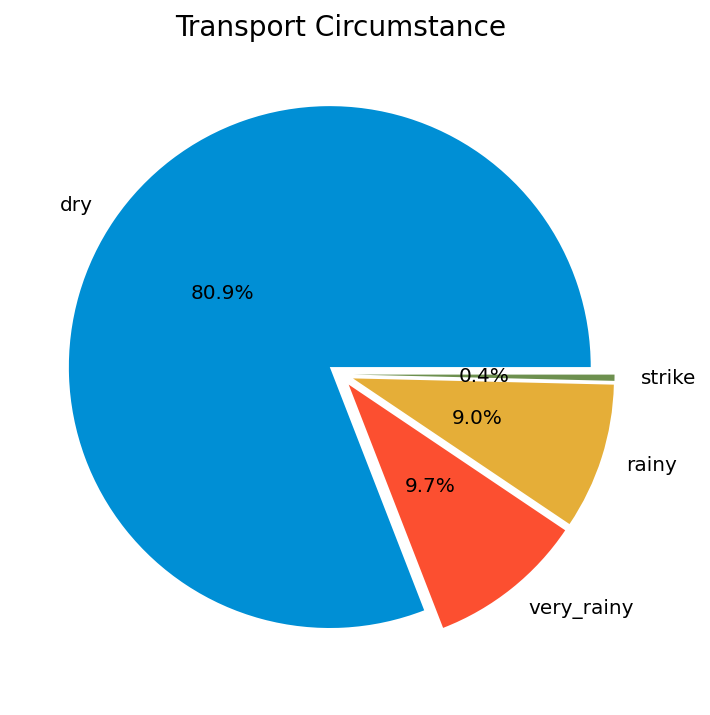

In [427]:
pie, ax = plt.subplots(figsize=[10,6])
labels = transport.circumstance.value_counts().index
plt.pie(x=transport.circumstance.value_counts(), autopct="%.1f%%", explode=[0.05]*4, labels=labels, pctdistance=0.5)
plt.title("Transport Circumstance", fontsize=14);
pie.savefig("CircumstancePieChart.png")
plt.show()

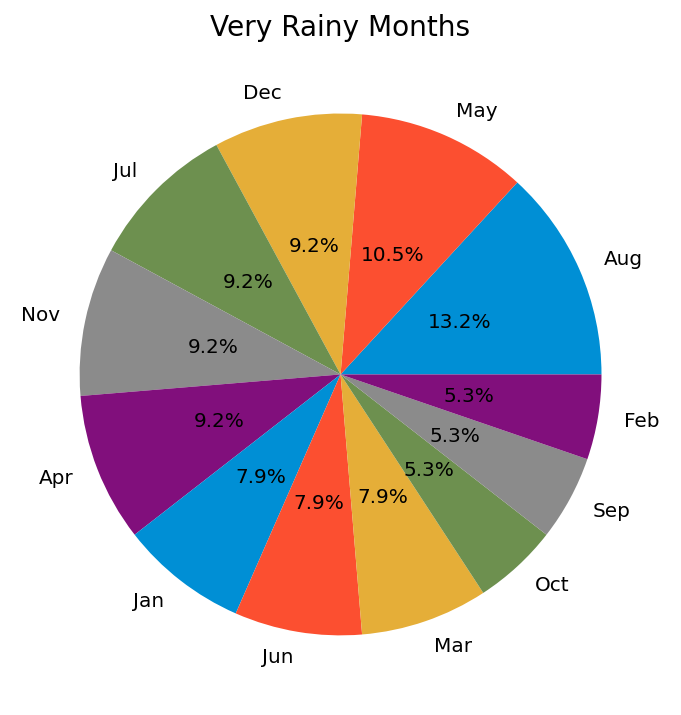

In [377]:
pie, ax = plt.subplots(figsize=[10,6])
labels = transport[transport.circumstance == 'very_rainy'].month.value_counts().index
plt.pie(x=transport[transport.circumstance == 'very_rainy'].month.value_counts(), autopct="%.1f%%",  labels=labels, pctdistance=0.5)
plt.title("Very Rainy Months", fontsize=14);


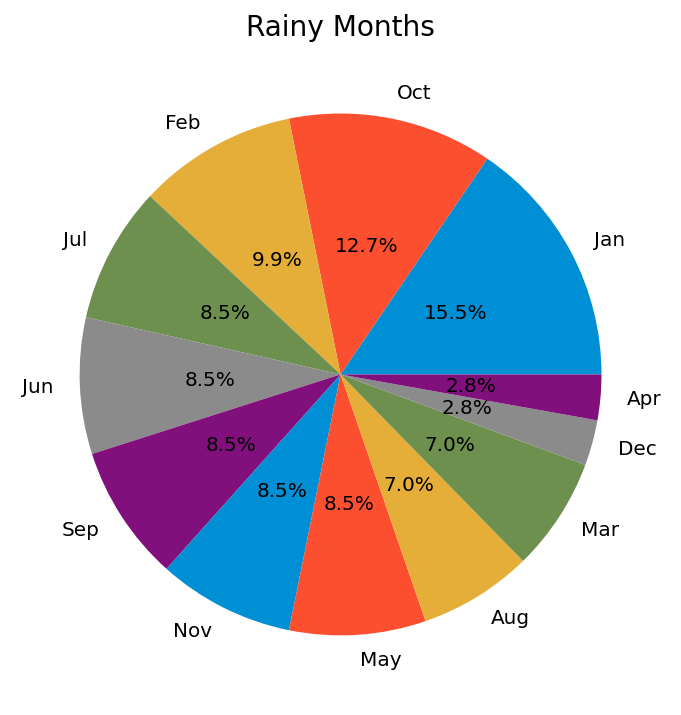

In [378]:
pie, ax = plt.subplots(figsize=[10,6])
labels = transport[transport.circumstance == 'rainy'].month.value_counts().index
plt.pie(x=transport[transport.circumstance == 'rainy'].month.value_counts(), autopct="%.1f%%",  labels=labels, pctdistance=0.5)
plt.title("Rainy Months", fontsize=14);


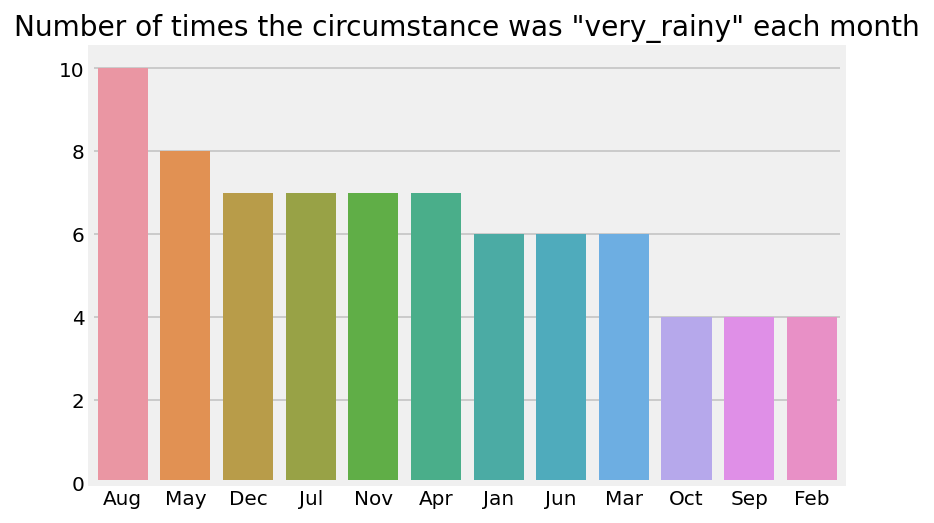

In [426]:

sns.barplot(transport[transport.circumstance == 'very_rainy'].month.value_counts().index,
            transport[transport.circumstance == 'very_rainy'].month.value_counts().values, 
           )
plt.title('Number of times the circumstance was "very_rainy" each month', fontsize = 14)
plt.savefig('very_rainy_by_month.png')
plt.show()


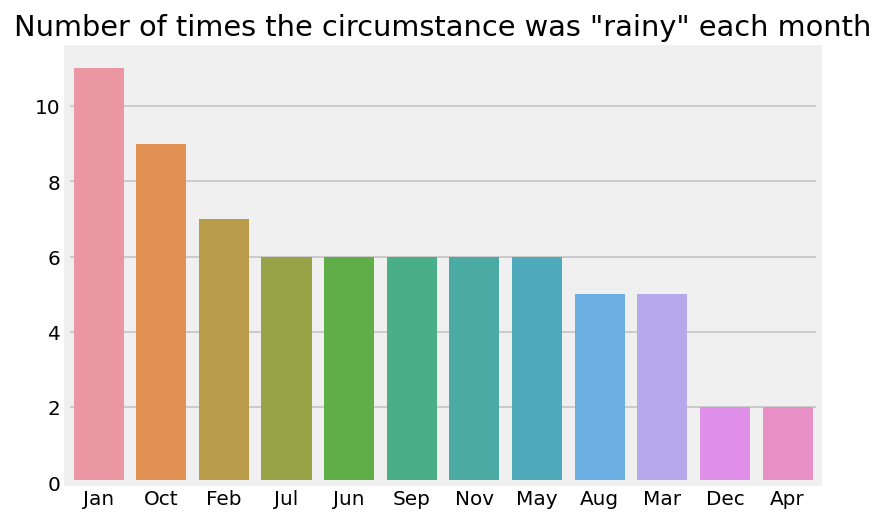

In [425]:
sns.barplot(transport[transport.circumstance == 'rainy'].month.value_counts().index,
        transport[transport.circumstance == 'rainy'].month.value_counts().values)
plt.title('Number of times the circumstance was "rainy" each month')
plt.savefig('rainy_by_month.png')
plt.show()

In [381]:
transport[transport.circumstance == 'strike']

,orders,circumstance,drivers_available,weekday,month,year
2012-02-05,28329.0,strike,5830.0,Sunday,Feb,2012
2013-07-22,34955.0,strike,6333.0,Monday,Jul,2013
2014-02-02,40188.0,strike,9106.0,Sunday,Feb,2014


In [382]:
transport[(transport.index == '2012-02-05')|(transport.index == '2012-02-04')|(transport.index == '2012-02-06')]

,orders,circumstance,drivers_available,weekday,month,year
2012-02-04,25417.0,dry,3924.0,Saturday,Feb,2012
2012-02-05,28329.0,strike,5830.0,Sunday,Feb,2012
2012-02-06,25353.0,dry,4351.0,Monday,Feb,2012


In [383]:
transport[(transport.index == '2013-07-22')|(transport.index == '2013-07-21')|(transport.index == '2013-07-23')]

,orders,circumstance,drivers_available,weekday,month,year
2013-07-21,30760.0,dry,5889.0,Sunday,Jul,2013
2013-07-22,34955.0,strike,6333.0,Monday,Jul,2013
2013-07-23,31523.0,dry,6212.0,Tuesday,Jul,2013


In [384]:
transport[(transport.index == '2014-02-02')|(transport.index == '2014-02-01')|(transport.index == '2014-02-03')]

,orders,circumstance,drivers_available,weekday,month,year
2014-02-01,39259.0,dry,5712.0,Saturday,Feb,2014
2014-02-02,40188.0,strike,9106.0,Sunday,Feb,2014
2014-02-03,39640.0,dry,8780.0,Monday,Feb,2014


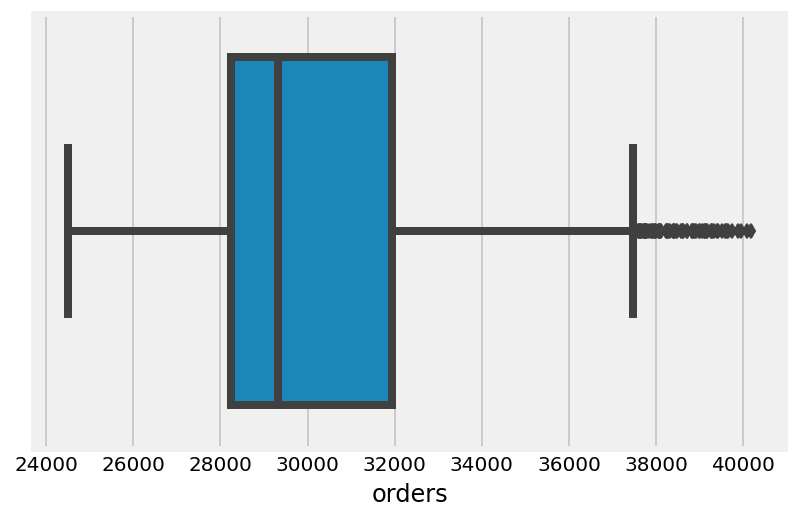

In [161]:
sns.boxplot(transport.orders)
plt.show()

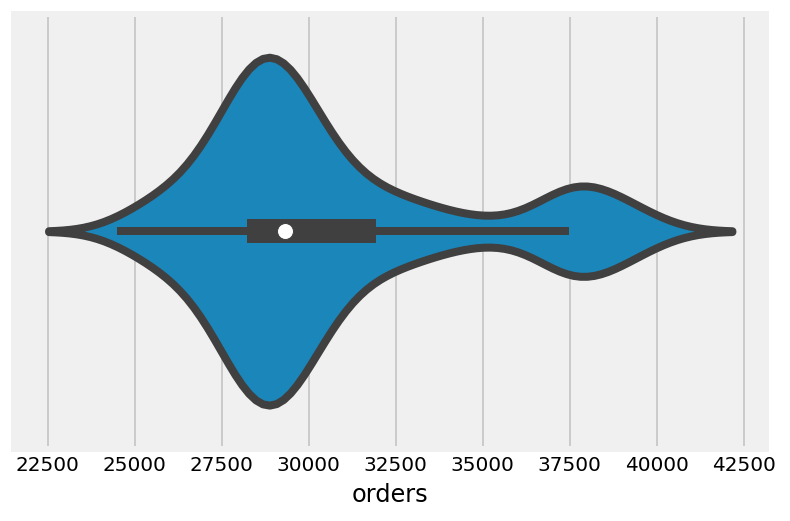

In [197]:
sns.violinplot(transport.orders)
plt.show()

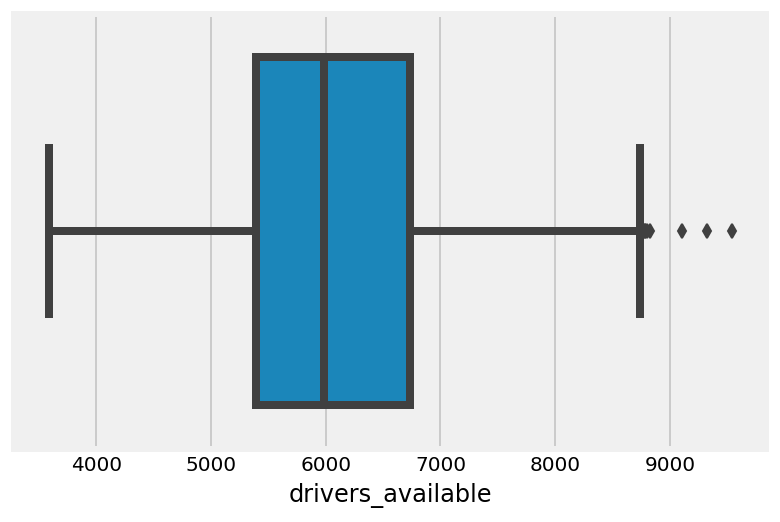

In [162]:
sns.boxplot(transport.drivers_available)
plt.show()

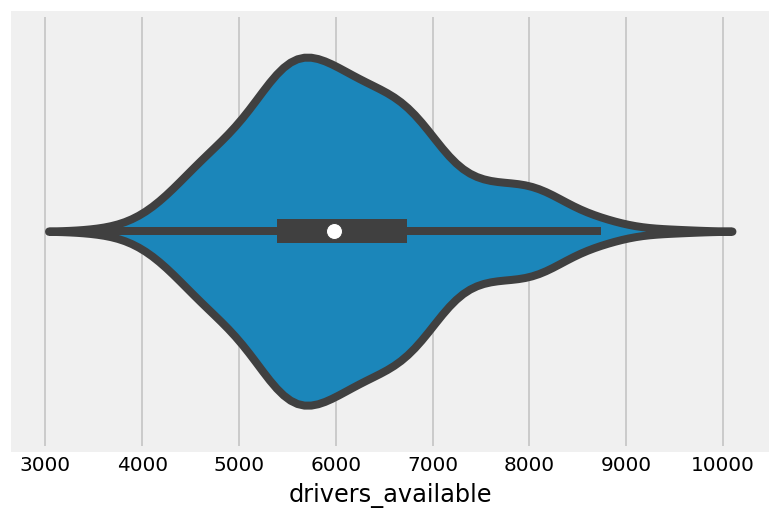

In [198]:
sns.violinplot(transport.drivers_available)
plt.show()

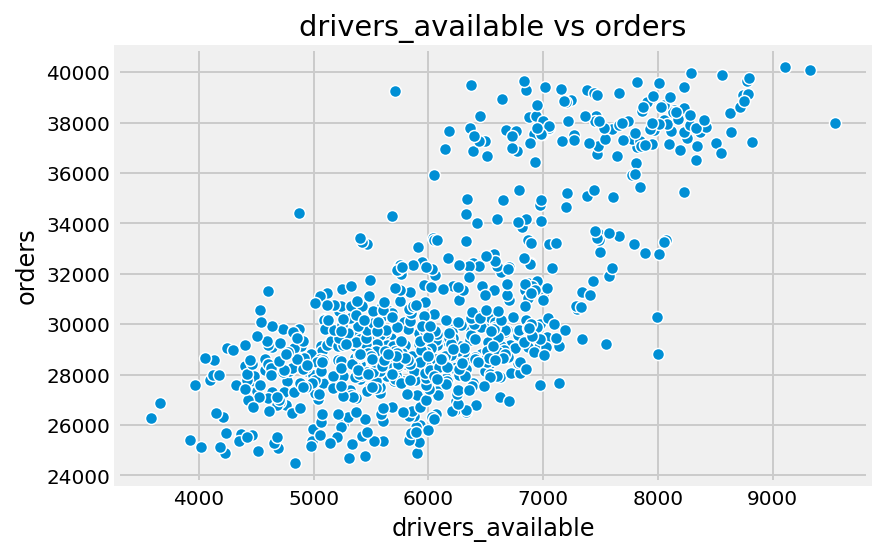

In [424]:
sns.scatterplot(transport.drivers_available, transport.orders)
plt.title('drivers_available vs orders')
plt.savefig('drivers_available_vs_orders.png')
plt.show()

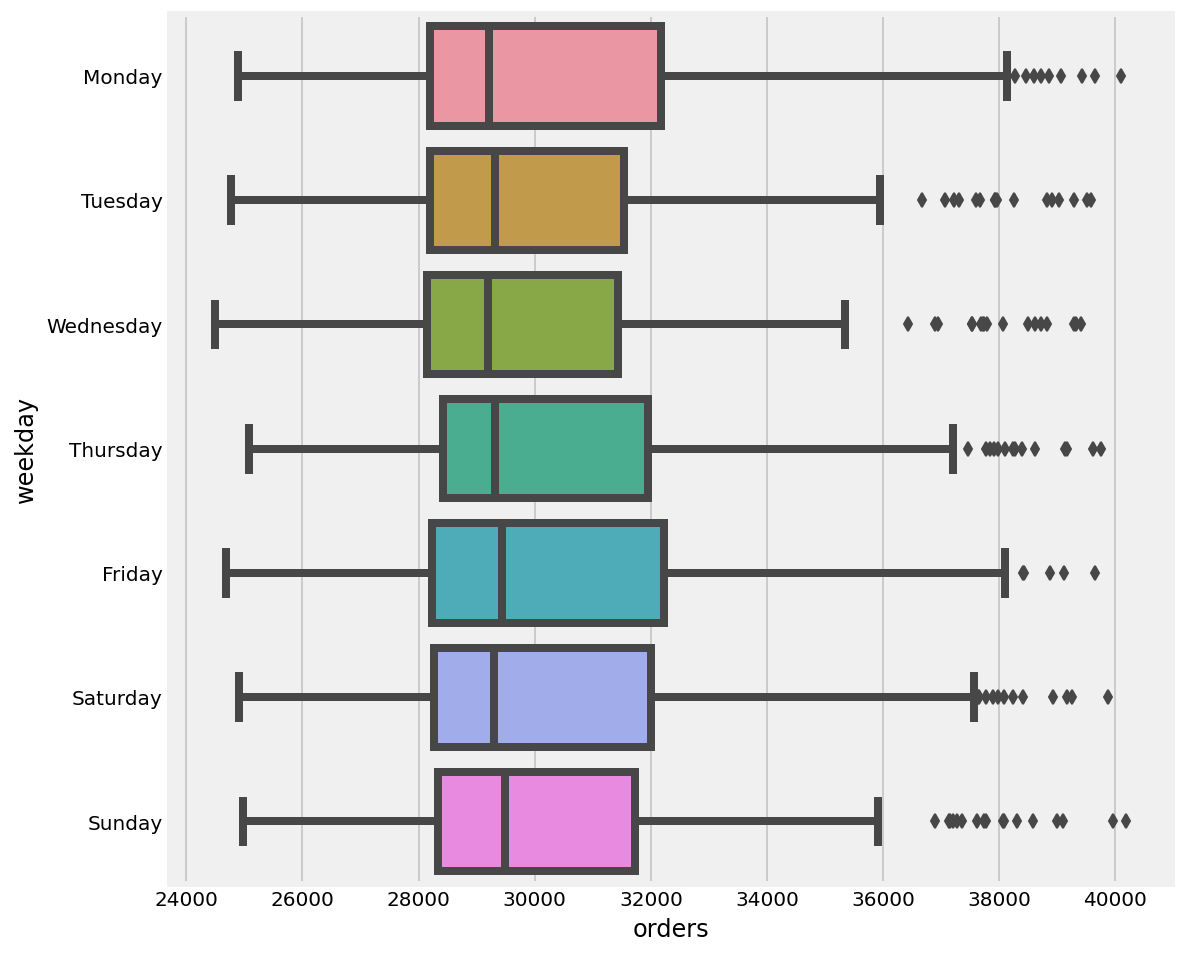

In [423]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(x = transport.orders, y = transport.weekday, ax = ax)
plt.savefig('weekday_orders.jpg')
plt.show()

In [223]:
transport.groupby(by = 'weekday').median().orders

weekday
Friday       29430.00
Monday       29220.00
Saturday     29296.75
Sunday       29488.50
Thursday     29318.00
Tuesday      29316.00
Wednesday    29190.00
Name: orders, dtype: float64

In [221]:
transport.groupby(by = 'weekday').describe().orders

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
Friday,112.0,30607.399554,3651.540276,24676.0,28225.00,29430.00,32218.00,39652.0
Monday,113.0,30577.415929,3904.848760,24899.0,28202.00,29220.00,32178.00,40089.0
Saturday,112.0,30601.745536,3758.465653,24905.0,28269.50,29296.75,32010.50,39872.0
Sunday,112.0,30660.919643,3695.882925,24980.0,28340.25,29488.50,31722.25,40188.0
Thursday,112.0,30662.285714,3724.317277,25083.0,28427.25,29318.00,31949.25,39755.5
Tuesday,112.0,30517.761161,3760.664991,24774.0,28190.25,29316.00,31545.75,39581.0
Wednesday,112.0,30506.595982,3750.322792,24498.0,28138.75,29190.00,31429.75,39402.0


In [435]:
transport.groupby(by = 'weekday').orders.mean().mean()

30590.589074069896

The average number of orders per day is very similar across the week surprisingly.

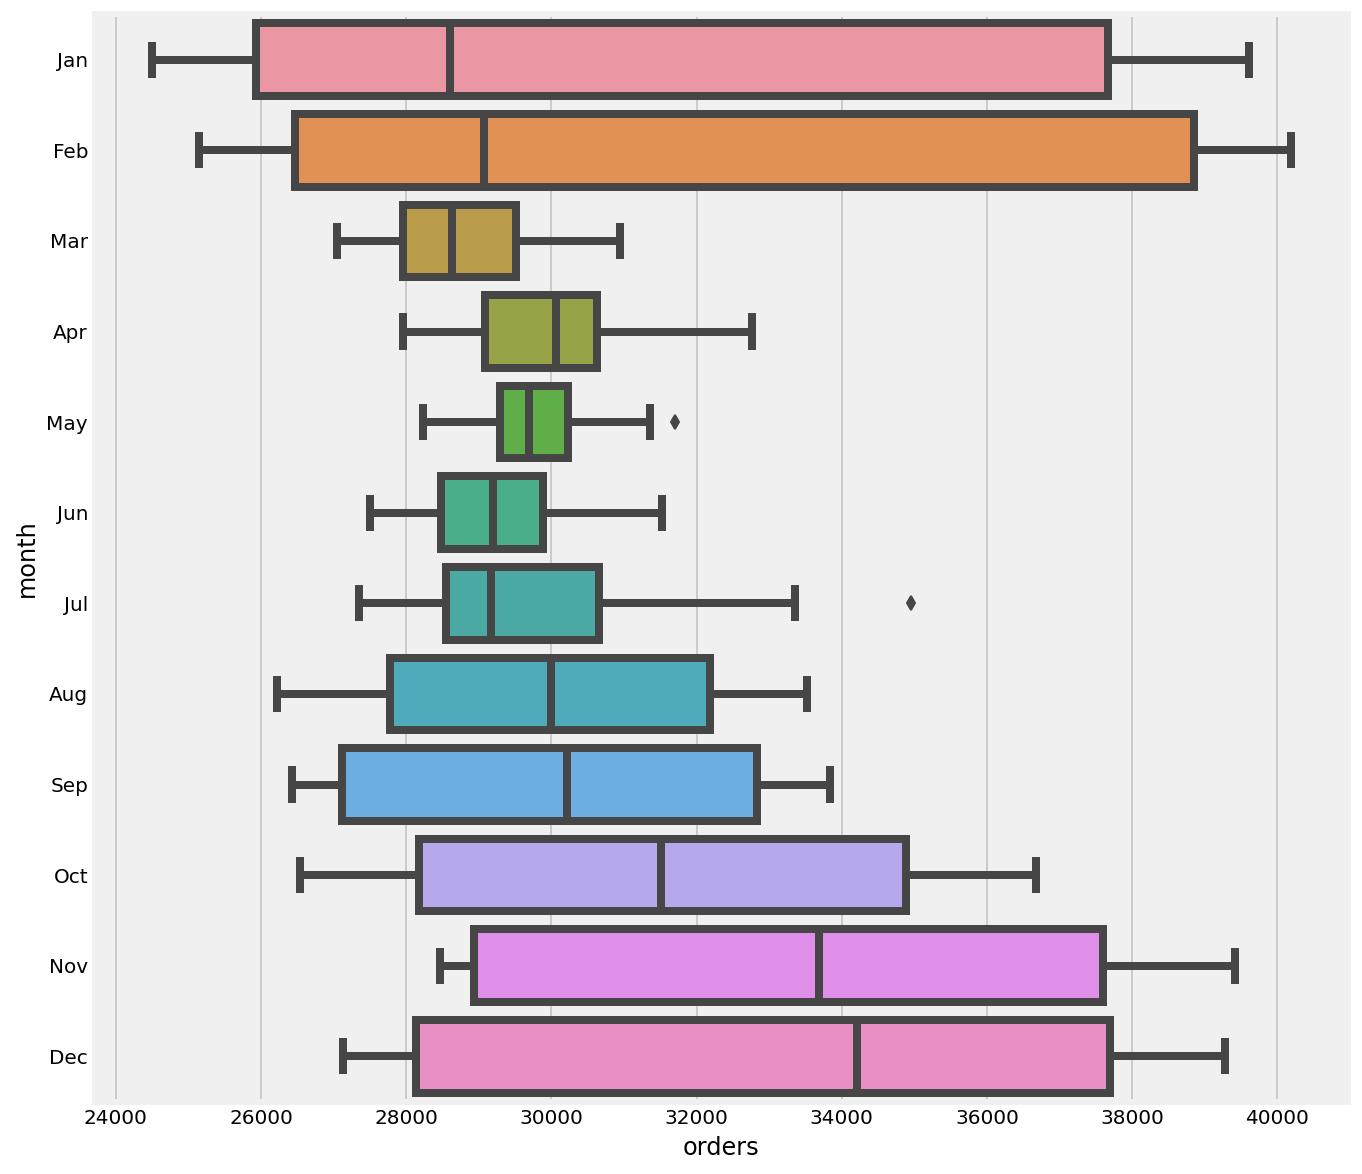

In [217]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = transport.orders, y = transport.month, ax = ax)
plt.show()

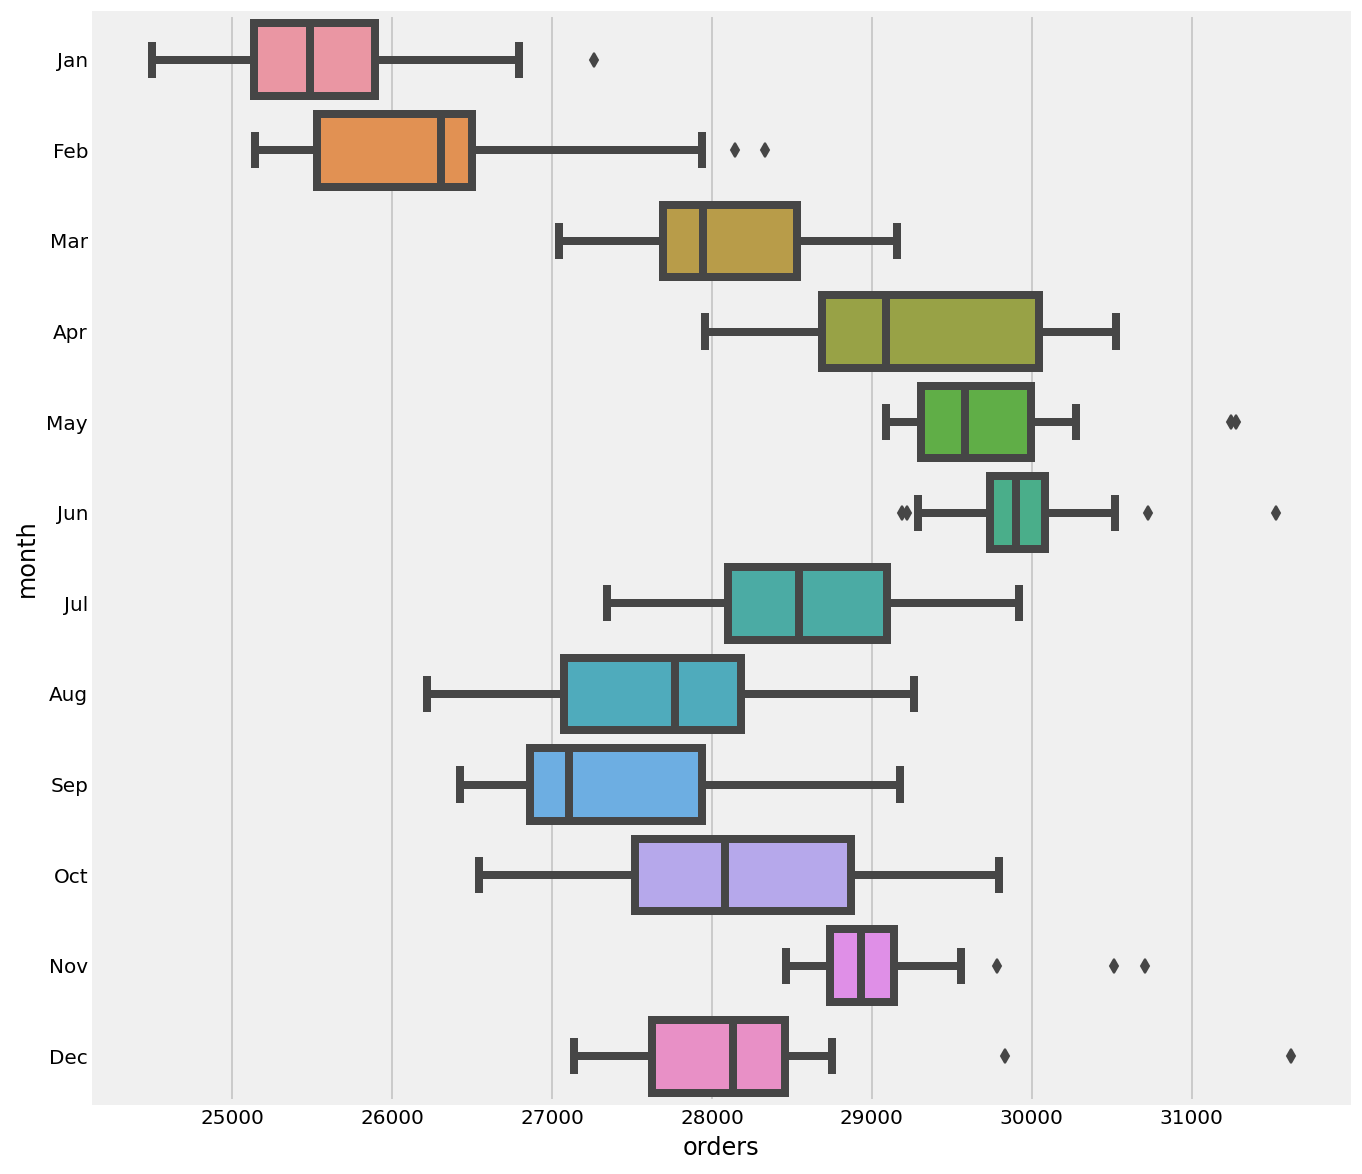

In [208]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = transport[transport.year == 2012].orders, y = transport[transport.year == 2012].month, ax = ax)
plt.show()

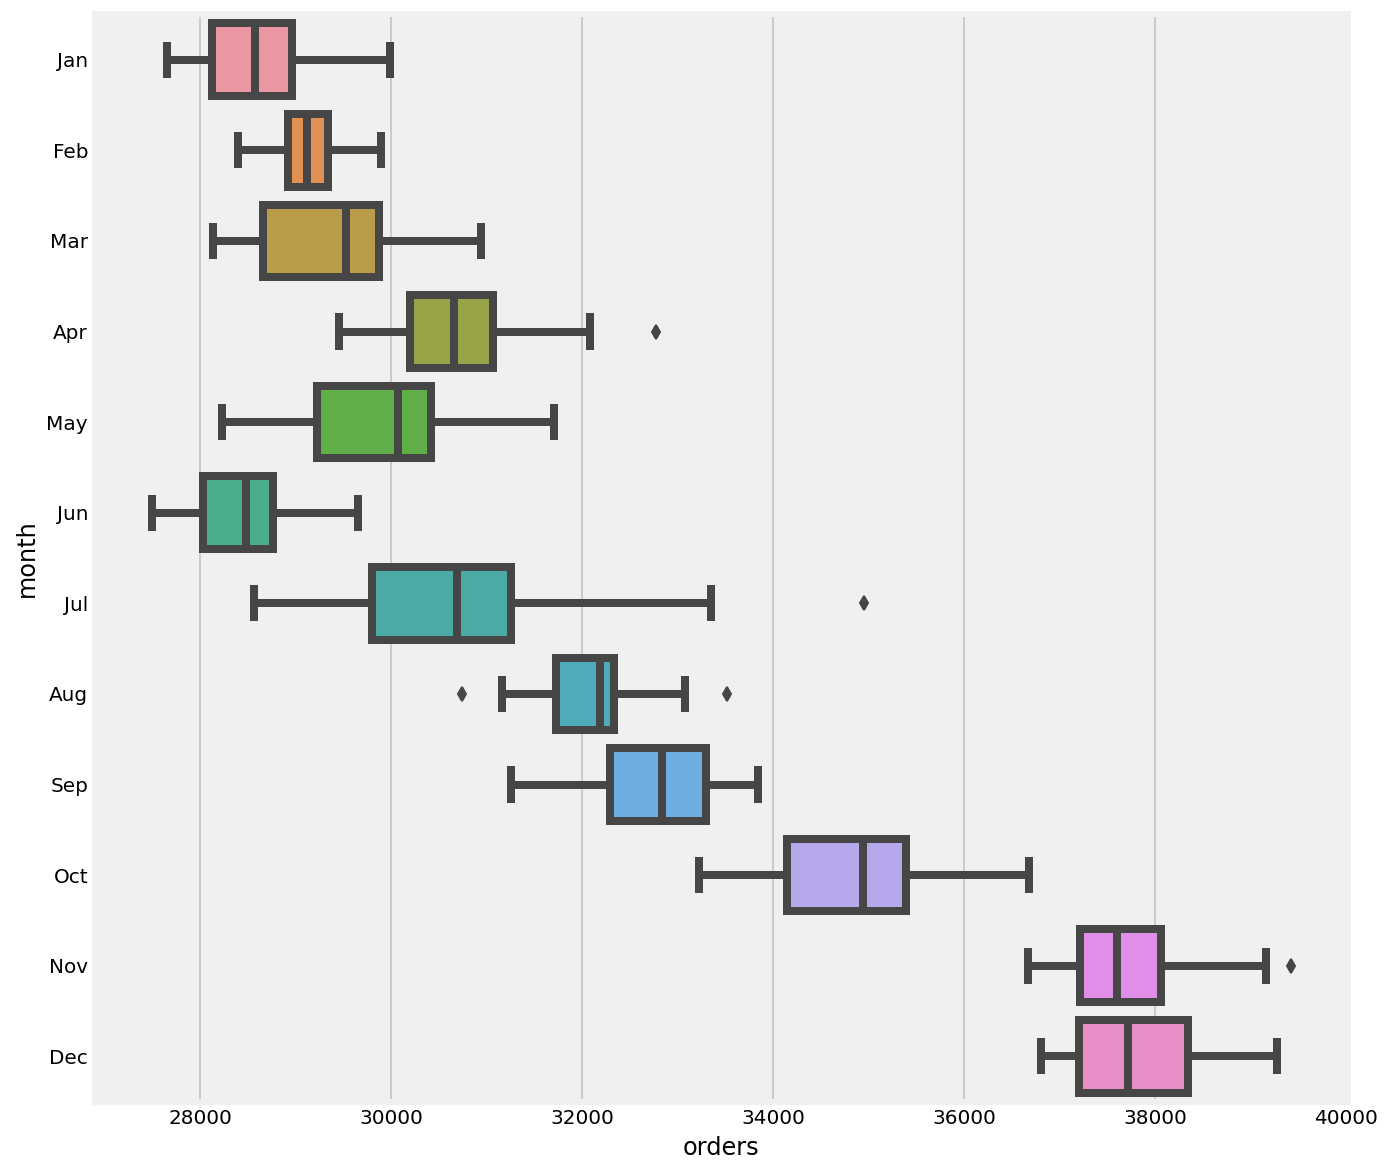

In [209]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x = transport[transport.year == 2013].orders, y = transport[transport.year == 2013].month, ax = ax)
plt.show()

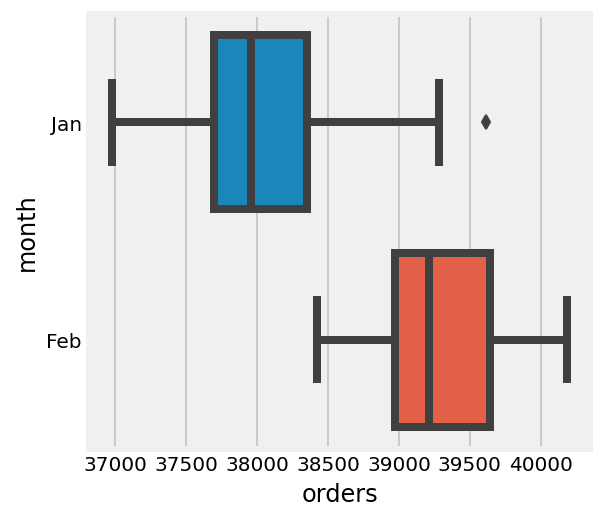

In [212]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(x = transport[transport.year == 2014].orders, y = transport[transport.year == 2014].month, ax = ax)
plt.show()

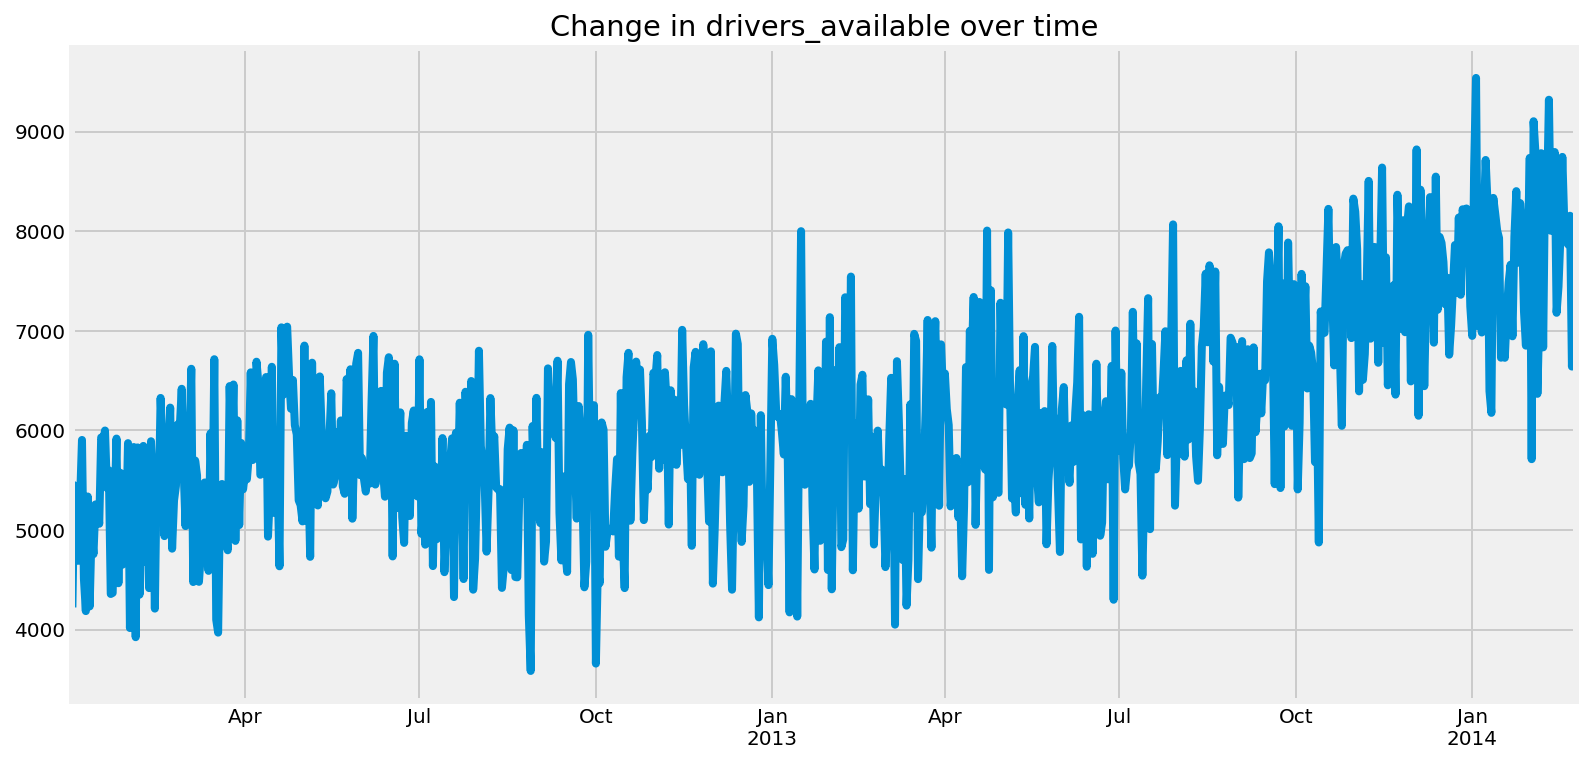

In [422]:
transport['drivers_available'].plot(figsize=(12, 6))
plt.title('Change in drivers_available over time')
plt.savefig('drivers_available_over_time.png')
plt.show()

In [440]:
transport.loc[:'2013-01-06'].drivers_available.std()

722.7685540067417

In [443]:
transport.loc['2013-01-06':].drivers_available.std()

1080.9861794590395

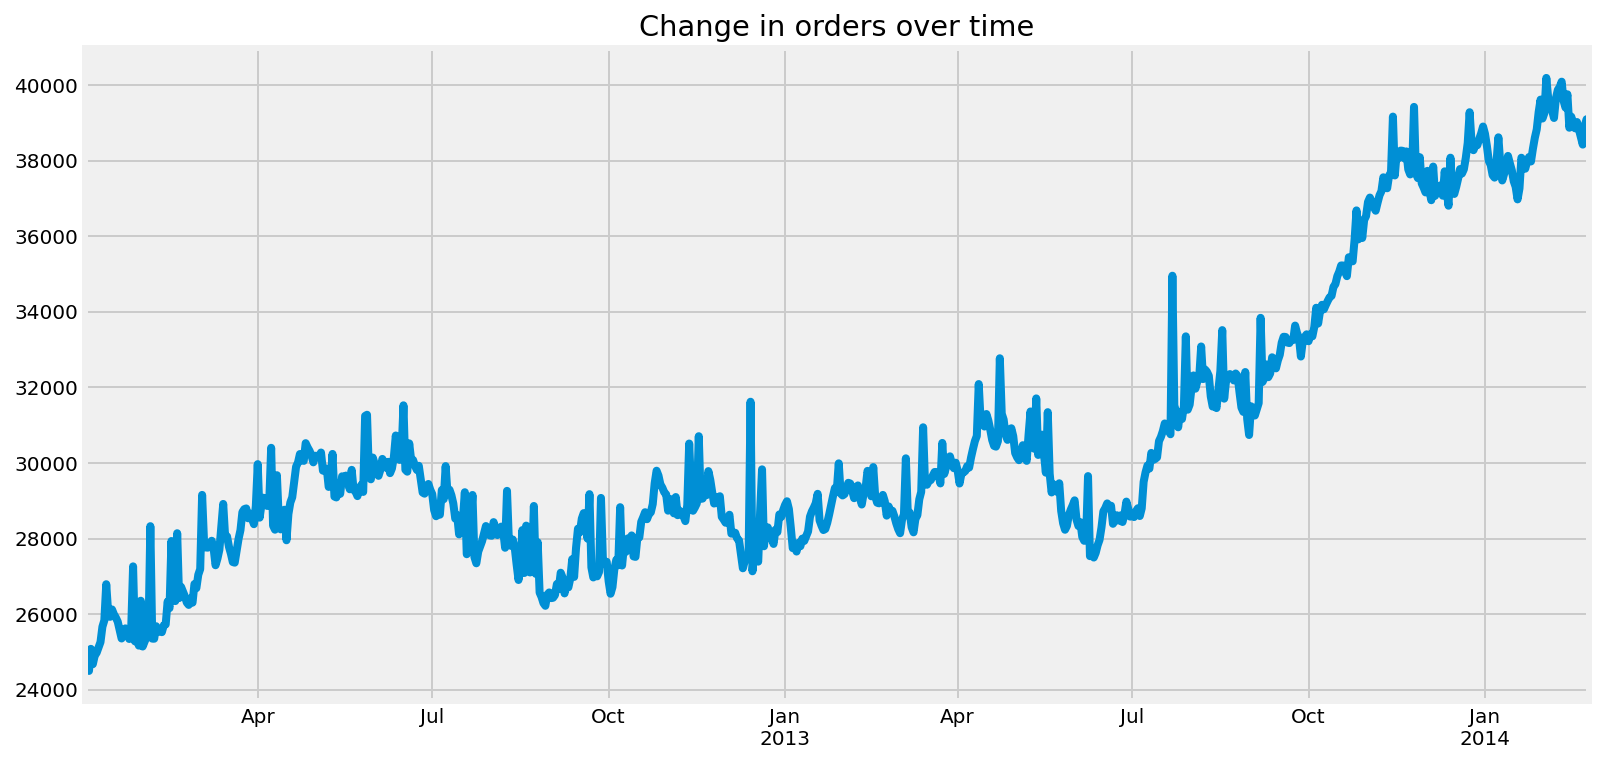

In [429]:
transport['orders'].plot(figsize=(12, 6))
plt.title('Change in orders over time')
plt.savefig('orders_over_time.png')
plt.show()

There don't appear to be any seasonal trends. Instead the number of daily orders and available drivers seem to rise and fall throughout 2012 and 2013, until July 2013, from which point the number of daily orders steadily rises into 2014. 

In [249]:
transport_dum = pd.get_dummies(transport, columns = ['circumstance', 'weekday', 'month', 'year'], drop_first = True)

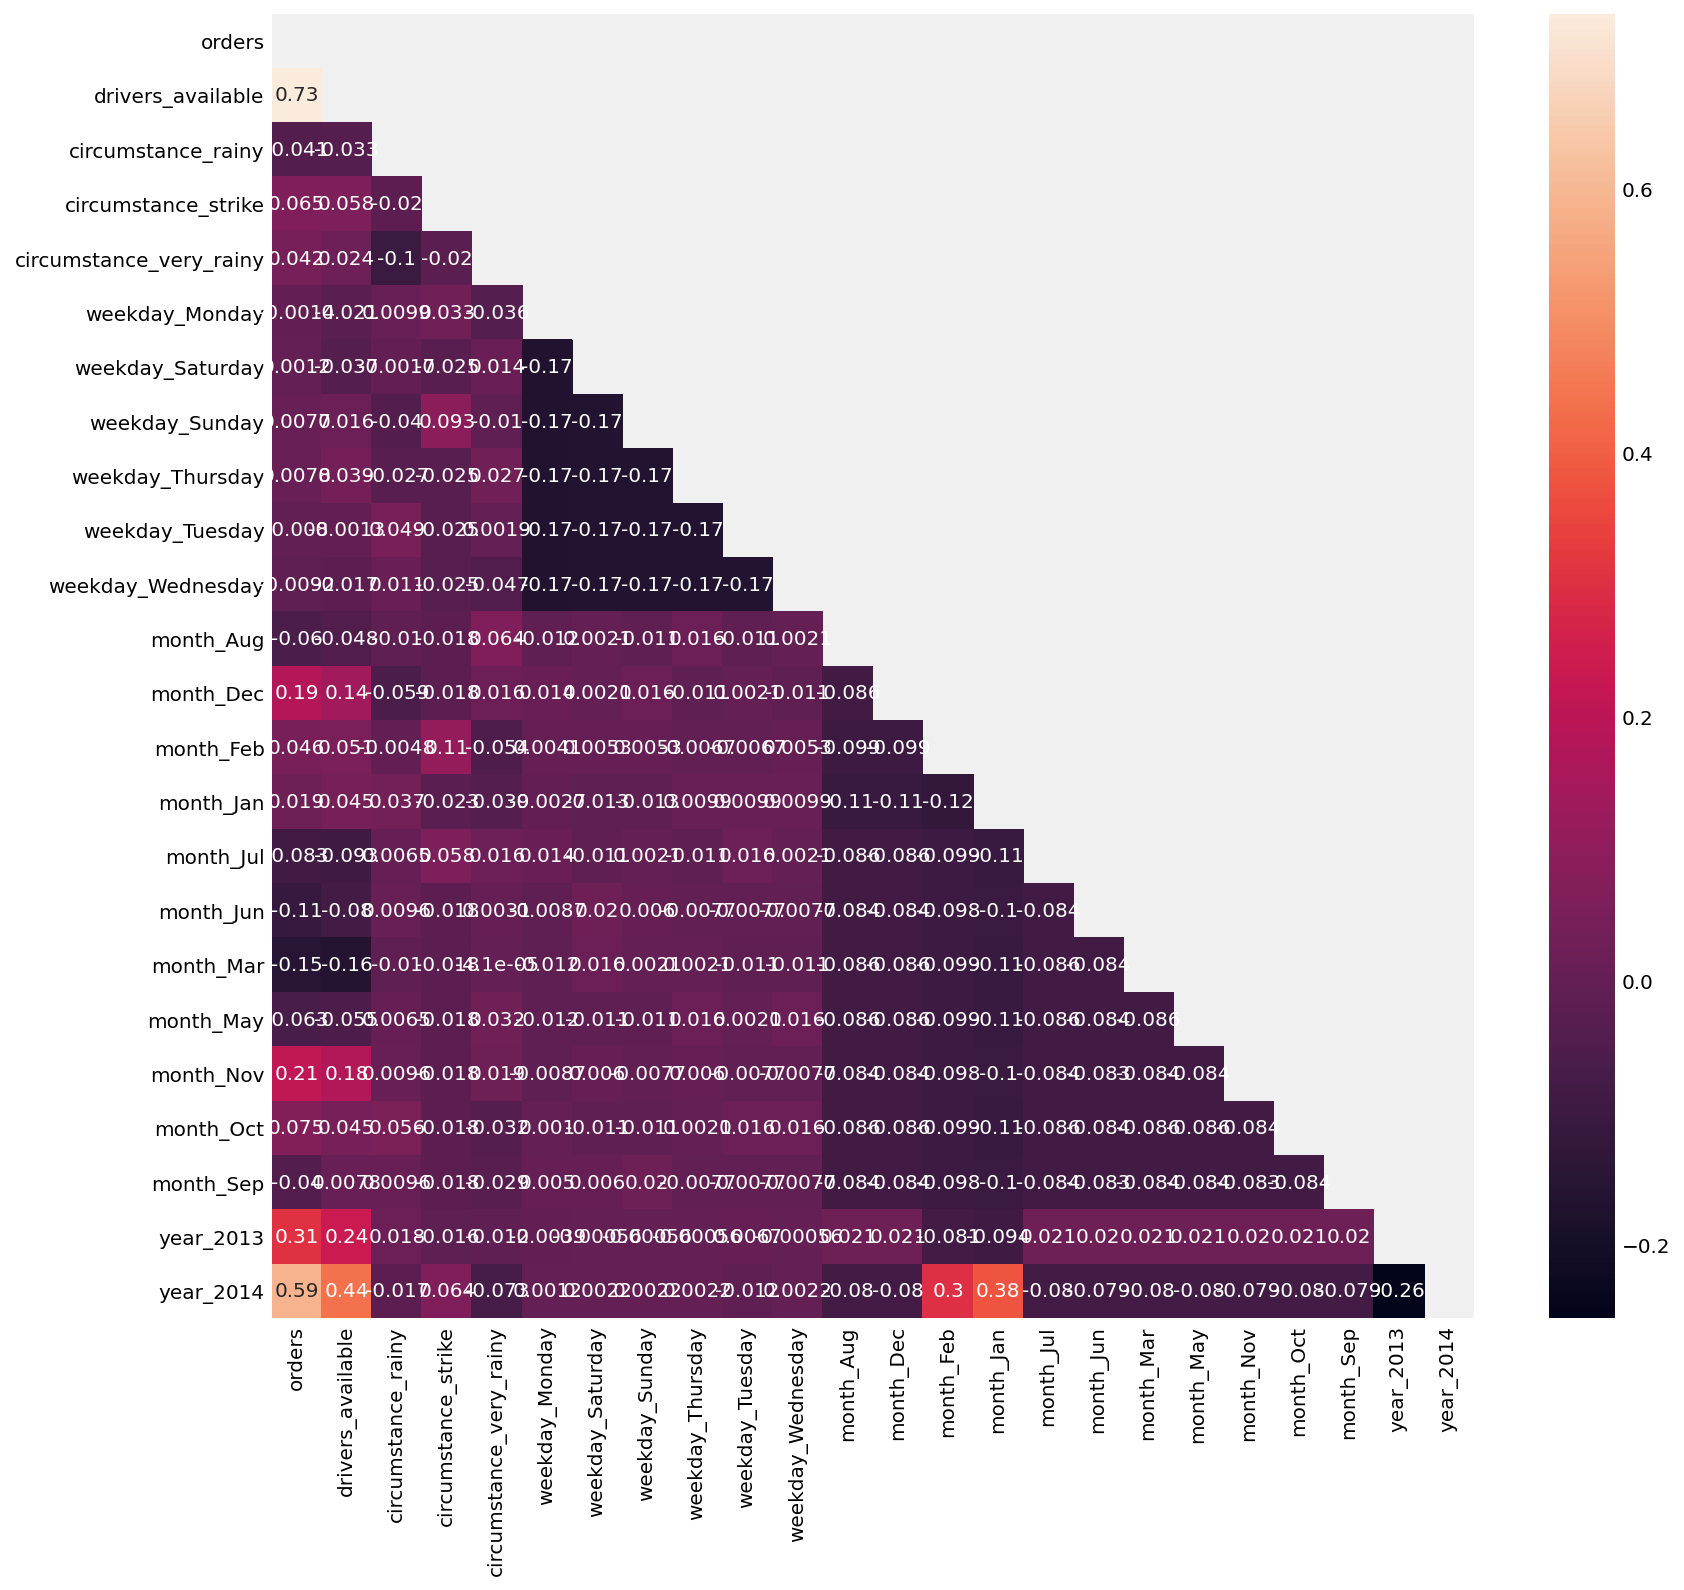

In [455]:
fig, ax = plt.subplots(figsize=(12, 12))

matrix = np.triu(transport_dum.corr())
sns.heatmap(transport_dum.corr(), annot=True, mask=matrix, ax = ax)
plt.savefig('corr_heatmap.png')
plt.show()

## Modelling

In [252]:
X = transport_dum.copy()
y = X.pop('orders')

In [447]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, LinearRegression, Ridge, RidgeCV

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [263]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('training score ', lr.score(X_train, y_train))
print('test score ', lr.score(X_test, y_test))
print('cross val score ', cross_val_score(lr, X_train, y_train, cv=5).mean())
pd.DataFrame(lr.coef_, index=X_train.columns,
                       columns=['coefficients']).sort_values(by = 'coefficients', ascending = False)

training score  0.826612534700641
test score  0.8471846384601903
cross val score  0.8078885844904594


,coefficients
year_2014,10687.310776
year_2013,2926.173732
month_Dec,2386.760113
month_Nov,2296.625575
circumstance_strike,1826.532004
month_Oct,1343.361213
circumstance_very_rainy,954.062954
weekday_Wednesday,56.373764
weekday_Saturday,48.619892
weekday_Thursday,30.532037


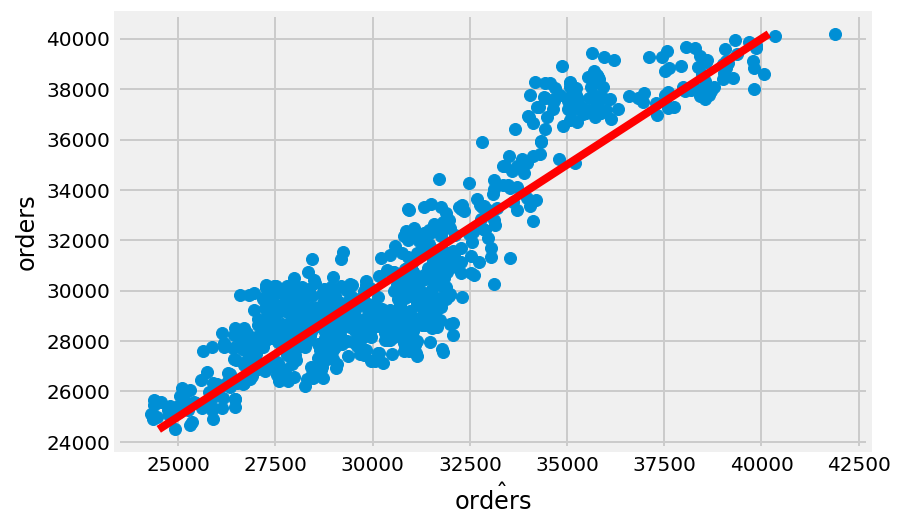

In [265]:
plt.scatter(lr.predict(X), y)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='r')
plt.xlabel(r'$\hat{\rm orders}$')
plt.ylabel('orders')
plt.show()

In [308]:
lr_ridge = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
lr_ridge.fit(X_train, y_train)
ridge_alpha = lr_ridge.alpha_
print(ridge_alpha)
ridge = Ridge(alpha = ridge_alpha)
ridge.fit(X_train, y_train)
print('training score', ridge.score(X_train, y_train))
print('cross val score', cross_val_score(ridge, X_train, y_train, cv = 5).mean())
print('test score', ridge.score(X_test, y_test))


0.3593813663804626
training score 0.8264560187489691
cross val score 0.8082168985311464
test score 0.8461912611697945


In [311]:
lr_lasso = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lr_lasso.fit(X_train, y_train)
lasso_alpha = lr_lasso.alpha_
print('alpha ', lasso_alpha)

lasso = Lasso(alpha = lasso_alpha)
lasso.fit(X_train, y_train)
print('training score', lasso.score(X_train, y_train))
print('cross val score', cross_val_score(lasso, X_train, y_train, cv = 5).mean())
print('test score', lasso.score(X_test, y_test))

      

alpha  2.782559402207126
training score 0.8261956187212832
cross val score 0.8091190240615924
test score 0.8460411463026891


In [275]:
lr_en = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                     cv=5)
lr_en.fit(X_train, y_train)
en_alpha = lr_en.alpha_
print('alpha ', en_alpha)
en_l1 = lr_en.l1_ratio_
print('l1_ratio ', en_l1)

elasticnet = ElasticNet(alpha=en_alpha, l1_ratio=en_l1)

# get cross validated scores
en_scores = cross_val_score(elasticnet, X_train, y_train, cv=5)
print("Mean cross-validated training score:", en_scores.mean())
# fit and evaluate the data on the whole training set
elasticnet.fit(X_train, y_train)
print("Training Score:", elasticnet.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", elasticnet.score(X_test, y_test))

alpha  2.782559402207126
l1_ratio  1.0
Cross-validated training scores: [0.77892211 0.77020236 0.84737493 0.82644445 0.82265127]
Mean cross-validated training score: 0.8091190240615924
Training Score: 0.8261956187212832
Test Score: 0.8460411463026891


Elastic net l1 ratio of 1.0 implies using lasso model is the best, this is also reflected in the Lasso model scoring slightly higher than the Ridge model.

In [313]:
pd.DataFrame(lasso.coef_, index=X_train.columns,
                       columns=['coefficients']).sort_values(by = 'coefficients', ascending = False)

,coefficients
year_2014,10483.683070
year_2013,2876.594502
month_Dec,2431.898796
month_Nov,2328.530462
month_Oct,1391.373783
circumstance_strike,1156.910241
circumstance_very_rainy,903.449455
month_Sep,43.063636
weekday_Wednesday,12.155397
weekday_Saturday,11.000510


In [453]:
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

In [454]:
lr_lasso = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lr_lasso.fit(X_train_std, y_train)
lasso_alpha = lr_lasso.alpha_
print('alpha ', lasso_alpha)

print('lasso')
lasso = Lasso(alpha = lasso_alpha)
lasso.fit(X_train_std, y_train)
print('training score', lasso.score(X_train_std, y_train))
print('cross val score', cross_val_score(lasso, X_train_std, y_train, cv = 5).mean())
print('test score', lasso.score(X_test_std, y_test))

pd.DataFrame(lasso.coef_, index=X_train.columns,
                       columns=['coefficients']).sort_values(by = 'coefficients', ascending = False)      

alpha  21.54434690031882
lasso
training score 0.8256508687955892
cross val score 0.8105056882565524
test score 0.8452253310564943


,coefficients
year_2014,2692.058248
year_2013,1410.861529
drivers_available,974.931950
month_Dec,659.973880
month_Nov,619.168374
month_Oct,362.875014
circumstance_very_rainy,258.909268
circumstance_strike,96.435223
month_Sep,12.294826
weekday_Thursday,0.000000


In [460]:
X_train.drivers_available.std()

1028.6172433856157

In [461]:
X_train.drivers_available.mean()

6093.004777070064

In [450]:
lr_en = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                     cv=5)
lr_en.fit(X_train_std, y_train)
en_alpha = lr_en.alpha_
print('alpha ', en_alpha)
en_l1 = lr_en.l1_ratio_
print('l1_ratio ', en_l1)

elasticnet = ElasticNet(alpha=en_alpha, l1_ratio=en_l1)

# get cross validated scores
en_scores = cross_val_score(elasticnet, X_train_std, y_train, cv=5)
print("Mean cross-validated training score:", en_scores.mean())
# fit and evaluate the data on the whole training set
elasticnet.fit(X_train_std, y_train)
print("Training Score:", elasticnet.score(X_train_std, y_train))
# evaluate the data on the test set
print("Test Score:", elasticnet.score(X_test_std, y_test))

alpha  21.54434690031882
l1_ratio  1.0
Mean cross-validated training score: 0.8105056882565524
Training Score: 0.8256508687955892
Test Score: 0.8452253310564943


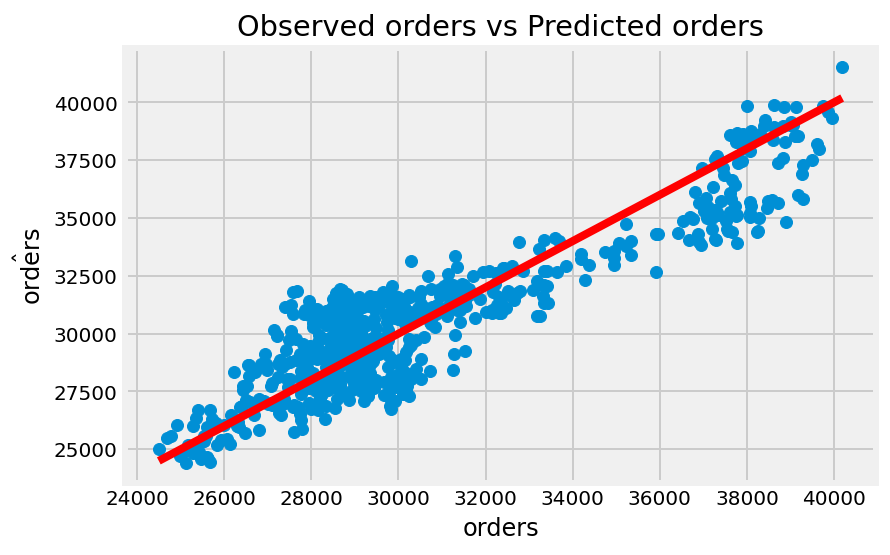

In [476]:
plt.scatter(y_train, lasso.predict(X_train_std))
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r')
plt.ylabel(r'$\hat{\rm orders}$')
plt.xlabel('orders')
plt.title('Observed orders vs Predicted orders')
plt.savefig('observed_vs_pred_lasso.png')
plt.show()

## Tree Based Regressors

In [277]:
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor

In [301]:
dtr = DecisionTreeRegressor(max_depth=12, random_state=1)
dtr.fit(X_train, y_train)
print(dtr.score(X_train, y_train))
print(cross_val_score(dtr, X_train, y_train, cv = 5).mean())
print(dtr.score(X_test, y_test))


model = DecisionTreeRegressor()
params = {'max_depth': [3,4, 5, 6,7,8,9,10,11,12,13],
          'max_features':[3,4,5,6,7,8, 9, 10],
          'max_leaf_nodes': [5, 6, 7, 8, 9, 10],
          'min_samples_leaf': [1, 2, 3, 4],
          'min_samples_split':[2,3,4]
          }

gs = GridSearchCV(model, param_grid=params, cv=5)
gs.fit(X_train, y_train)

model = gs.best_estimator_
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 CV training: ', gs.best_score_)
print('R2 test: ', gs.score(X_test, y_test))

0.9803236770238016
0.9119542031783887
0.9525953747686849
DecisionTreeRegressor(max_depth=8, max_features=9, max_leaf_nodes=10,
                      min_samples_leaf=3, min_samples_split=3)
R2 training:  0.7812479727870875
R2 CV training:  0.8401355022081614
R2 test:  0.8071577642395854


In [314]:
pd.DataFrame(model.feature_importances_, 
             index = X_train.columns,
             columns=['coefficients']).sort_values(by = 'coefficients', 
                                                   ascending = False).head(20)

,coefficients
drivers_available,0.748700
year_2013,0.114151
year_2014,0.066546
month_Nov,0.041813
month_Dec,0.018540
month_Oct,0.010250
weekday_Monday,0.000000
circumstance_strike,0.000000
month_Sep,0.000000
month_May,0.000000


In [316]:
etr = ExtraTreeRegressor()
etr.fit(X_train, y_train)
print(etr.score(X_train, y_train))
print(cross_val_score(etr, X_train, y_train, cv = 5).mean())
print(etr.score(X_test, y_test))

0.9999821697070536
0.9283742708849001
0.9323712136093364


In [317]:
abr = AdaBoostRegressor()
abr.fit(X_train, y_train)
print(abr.score(X_train, y_train))
print(cross_val_score(abr, X_train, y_train, cv = 5).mean())
print(abr.score(X_test, y_test))

0.8309667481569236
0.7992939845196402
0.8091927229062537


In [319]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
print(gbr.score(X_train, y_train))
print(cross_val_score(gbr, X_train, y_train, cv = 5).mean())
print(gbr.score(X_test, y_test))

0.9471881121116855
0.9120244443522114
0.9261604921444158


In [318]:
bagr = BaggingRegressor()
bagr.fit(X_train, y_train)
print(bagr.score(X_train, y_train))
print(cross_val_score(bagr, X_train, y_train, cv = 5).mean())
print(bagr.score(X_test, y_test))

0.9894827987975148
0.9337275383975217
0.9581860645561756


In [444]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
print(rfr.score(X_train, y_train))
print(cross_val_score(rfr, X_train, y_train, cv = 5).mean())
print(cross_val_score(rfr, X_train, y_train, cv = 5))

print(rfr.score(X_test, y_test))


0.9923423762745402
0.9361826633306336
[0.91017663 0.92661311 0.93432145 0.9683656  0.95660931]
0.9591214106343114


In [446]:
pd.DataFrame(rfr.feature_importances_, 
             index = X_train.columns,
             columns=['coefficients']).sort_values(by = 'coefficients', 
                                                   ascending = False).head(20)

,coefficients
drivers_available,0.559023
year_2014,0.107876
year_2013,0.086320
month_Nov,0.053029
month_Dec,0.040541
month_Oct,0.031418
month_Jan,0.025936
month_Sep,0.020453
month_Feb,0.016372
month_Aug,0.016185


The Random Forest Regressor performed the best across the Cross Validated Training Score and Test Score. 

In [463]:
rfr = RandomForestRegressor()
rfr.fit(X_train_std, y_train)
print('Random Forest Regressor')
print('Training score ', rfr.score(X_train_std, y_train))
print('Cross Val Training Score ', cross_val_score(rfr, X_train_std, y_train, cv = 5).mean())
#print(cross_val_score(rfr, X_train_std, y_train, cv = 5))

print('Test Score ', rfr.score(X_test_std, y_test))


Random Forest Regressor
Training score  0.9916290182701507
Cross Val Training Score  0.9399783256807153
Test Score  0.9585654448572829


In [464]:
pd.DataFrame(rfr.feature_importances_, 
             index = X_train_std.columns,
             columns=['coefficients']).sort_values(by = 'coefficients', 
                                                   ascending = False)

,coefficients
drivers_available,0.556071
year_2014,0.107324
year_2013,0.085125
month_Nov,0.055118
month_Dec,0.043607
month_Oct,0.031262
month_Jan,0.025368
month_Sep,0.021016
month_Feb,0.016346
month_Aug,0.015230


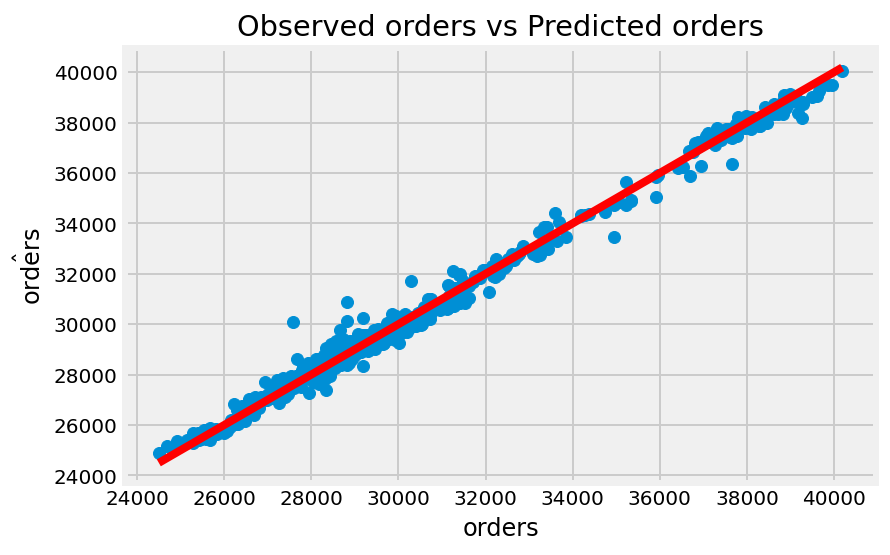

In [477]:
plt.scatter(y_train, rfr.predict(X_train_std))
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r')
plt.ylabel(r'$\hat{\rm orders}$')
plt.xlabel('orders')
plt.title('Observed orders vs Predicted orders')
plt.savefig('observed_vs_pred_random_forest.png')
plt.show()